# Building a Retrieval Augmented Generation (RAG) Pipeline with LlamaIndex, Azure AI Search, Azure OpenAI, Literal AI, and RAGAS
In this notebook, we will build a Retrieval Augmented Generation (RAG) system from scratch using LlamaIndex, Azure AI Search as the vector store, Azure OpenAI as the Large Language Model (LLM), and integrate Literal AI for logging, evaluation, and visualization. We will use RAGAS for evaluating our RAG system.

## Initial Setup
First, we'll install the necessary libraries and set up our environment.
### Install Necessary Libraries

In [ ]:
# Install necessary libraries
!pip install llama-index
!pip install ragas
!pip install azure-search-documents==11.5.2
!pip install llama-index-vector-stores-azureaisearch
!pip install llama-index-llms-azure-openai
!pip install llama-index-embeddings-azure-openai
!pip install literalai
!pip install datasets
!pip install nest_asyncio

### Import Required Modules

In [1]:
# Import modules
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.aio import SearchIndexClient as AsyncSearchIndexClient 
from azure.search.documents.aio import SearchClient as AsyncSearchClient
import pandas as pd
import matplotlib.pyplot as plt


from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType
import os
import asyncio
from azure.storage.blob.aio import BlobServiceClient
from dotenv import load_dotenv
from llama_parse import LlamaParse
import re
from copy import deepcopy
from typing import Dict, List
from llama_index.core.schema import TextNode, MetadataMode
import nest_asyncio
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
# Example usage of MultimodalQueryEngine
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from llama_index.core import get_response_synthesizer
import os
import time
from literalai import LiteralClient

from dotenv import load_dotenv
from datasets import Dataset
from ragas import evaluate as ragas_evaluate
from ragas.metrics import answer_relevancy, context_precision, context_recall, faithfulness
from IPython.display import Markdown, display

### Load Environment Variables and Set Up Credentials
We will load our credentials from a .env file or environment variables. Make sure you have your Azure OpenAI, Azure AI Search, and Literal AI credentials ready.

In [2]:
load_dotenv()

# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "llamaindex-azure-aisearch-rag-literal-ai"

# Initialize LLM and Embedding models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-10-01-preview"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-10-01-preview"
)

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)

async_index_client = AsyncSearchIndexClient(
    endpoint=SEARCH_SERVICE_ENDPOINT, 
    credential=credential
)

async_search_client = AsyncSearchClient(
    endpoint=SEARCH_SERVICE_ENDPOINT,
    index_name=INDEX_NAME,
    credential=credential
)

LITERAL_API_KEY = os.getenv('LITERAL_API_KEY')

# Initialize Literal AI client
literalai_client = LiteralClient(api_key=LITERAL_API_KEY)
literalai_client.instrument_llamaindex()

## Load and Prepare Data
We'll load the documents we want to index and prepare them for the RAG system.

### Load Documents
Assuming you have a directory data/pdf containing your PDF documents.

In [3]:
# Load documents 
documents = SimpleDirectoryReader('data/pdf').load_data()

## Build the RAG Pipeline
We'll create an index using LlamaIndex with Azure AI Search as the vector store, and configure Azure OpenAI as the LLM.
### Set Up the Vector Store

In [4]:
vector_store = AzureAISearchVectorStore(
    search_or_index_client=index_client,
    index_name=INDEX_NAME,
    index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
    id_field_key="id",
    chunk_field_key="chunk",
    embedding_field_key="embedding",
    embedding_dimensionality=1536, 
    metadata_string_field_key="metadata",
    doc_id_field_key="doc_id",
    language_analyzer="en.lucene",
    vector_algorithm_type="exhaustiveKnn",
    compression_type="scalar" # Option to use "scalar" or "binary". NOTE: compression is only supported for HNSW
)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Create index with text splitter
index = VectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

query_engine = index.as_query_engine(similarity_top_k=1)

In [5]:
response = query_engine.query("Does my benefits cover scuba diving?")
display(Markdown(f"{response}"))

Yes, your benefits cover scuba diving lessons as part of the PerksPlus program.

In [6]:
async_vector_store = AzureAISearchVectorStore(
    search_or_index_client=async_search_client,
    index_management=IndexManagement.VALIDATE_INDEX,
    id_field_key="id",
    chunk_field_key="chunk",
    embedding_field_key="embedding",
    embedding_dimensionality=1536, 
    metadata_string_field_key="metadata",
    doc_id_field_key="doc_id",
    language_analyzer="en.lucene",
    vector_algorithm_type="exhaustiveKnn",
    compression_type="scalar" # Option to use "scalar" or "binary". NOTE: compression is only supported for HNSW
)

async_storage_context = StorageContext.from_defaults(vector_store=async_vector_store)

# Create index with text splitter
async_index = VectorStoreIndex.from_documents(
    [],
    storage_context=async_storage_context,
)

In [7]:
async_query_engine = async_index.as_query_engine(similarity_top_k=1)

In [8]:
# Use the async query engine
import asyncio
nest_asyncio.apply()
response = asyncio.run(async_query_engine.aquery("What is the main idea of the essay?"))
print("Async query response:", response)

Async query response: The main idea of the essay revolves around understanding the primary and secondary payer rules of the Northwind Health Plus plan, including the exceptions that apply when individuals have other health coverage. It emphasizes the importance of knowing one's coverage type, keeping track of medical expenses, understanding the rules of each plan, being aware of claim filing deadlines, and seeking assistance when needed to ensure proper coordination of benefits and timely processing of claims.


## Prepare the Evaluation Dataset
We'll create an evaluation dataset consisting of questions and their corresponding ground truth answers. This dataset will be used to evaluate our RAG system's performance.
### Create Evaluation Data

In [9]:
# Prepare evaluation data
evaluation_data = [
    {
        "question": "What are out-of-network providers and what are the implications of receiving care from them?",
        "ground_truth": "Out-of-network providers are those who have not contracted with Northwind Health. As a result, they are not required to accept the amount of payment offered by Northwind Health, meaning that the patient may be responsible for a greater portion of the cost. Additionally, out-of-network providers may not offer additional services or discounts that are available to in-network providers."
    },
    {
        "question": "Why is it important to ensure that a healthcare provider is in-network?",
        "ground_truth": "It is important to ensure that a healthcare provider is in-network because while it is possible to receive care from out-of-network providers, it is important to understand that the patient will be responsible for a greater portion of the costs. Choosing an in-network provider whenever possible is recommended to ensure the best value for health care expenses."
    },
    {
        "question": "Under what circumstances can one receive care from out-of-network providers?",
        "ground_truth": "If one is unable to find an in-network provider in their area or if they require a specific type of care that is not available from an in-network provider, they may receive care from an out-of-network provider. However, in these cases, the cost of care may be more expensive and the patient may be responsible for a greater portion of the costs."
    },
    {
        "question": "Does the deductible roll over into the next year?",
        "ground_truth": "No, the deductible does not roll over into the next year. This means that the deductible amount must be met in the current year before the insurance begins to pay."
    },
    {
        "question": "When does the deductible not apply to services?",
        "ground_truth": "The deductible may not apply to all services. For example, it may not apply when receiving in-network emergency services."
    },
    # Harder RAG Questions
    {
        "question": "What is the coverage policy for mental health treatment under the Northwind Standard plan?",
        "ground_truth": "Northwind Standard does not cover mental health services, including therapy and psychiatric care, unless specifically mentioned in the policy. Coverage for mental health treatment may require additional approval or separate insurance."
    },
    {
        "question": "What are the potential reasons for Northwind Health to deny coverage for a non-emergency out-of-network service?",
        "ground_truth": "Northwind Health may deny coverage for non-emergency out-of-network services if they are deemed medically unnecessary, if preauthorization was not obtained, or if the service is not covered under the plan’s benefits."
    },
    {
        "question": "What steps should an individual take if they wish to appeal a denied claim for an out-of-network provider under the Northwind Standard plan?",
        "ground_truth": "To appeal a denied claim for an out-of-network provider, an individual should gather any relevant medical records and documentation, contact Northwind Health’s claims department, and submit a formal appeal. The appeal will be reviewed by a medical review board to determine if the claim meets coverage criteria."
    },
    {
        "question": "How does Northwind Health determine medical necessity for out-of-network services?",
        "ground_truth": "Northwind Health determines medical necessity for out-of-network services based on clinical guidelines, patient history, and the severity of the condition. If the service is deemed not medically necessary, it may not be covered under the plan."
    },
    {
        "question": "What is the impact of receiving care from an out-of-network provider on the Northwind Standard plan’s coverage for prescription drugs?",
        "ground_truth": "Receiving care from an out-of-network provider does not directly affect prescription drug coverage, but prescriptions filled outside the network may incur higher out-of-pocket costs. Additionally, certain medications may not be covered under out-of-network plans."
    },
]


## Upload Evaluation Data to Literal AI
We'll create a dataset in Literal AI and upload our evaluation data. This will allow us to compare different experiments later.

In [10]:
# Create dataset in Literal AI
DATASET_NAME = "Contoso-HR Evaluation Dataset"
literal_dataset = literalai_client.api.create_dataset(name=DATASET_NAME, description="Evaluation dataset for Contoso-HR")

# Upload data to Literal AI dataset
for item in evaluation_data:
    literal_dataset.create_item(
        input={"content": item["question"]},
        expected_output={"content": item["ground_truth"]}
    )


## Prepare Data for RAGAS Evaluation
We'll transform the evaluation data into a format that RAGAS understands.

In [11]:
# Retrieve dataset items from Literal AI
experiment_items = literal_dataset.items

# Extract questions and ground truths
questions = []
ground_truths = []

for item in experiment_items:
    question = item.input["content"]
    ground_truth = item.expected_output["content"]
    questions.append(question)
    ground_truths.append(ground_truth)

from datasets import Dataset

data_samples = {
    'question': questions,
    'ground_truth': ground_truths
}
# Convert dict to dataset
# To escape the issue with evaluate function later. Dataset should be of this dataset type, not just dict.
data_samples_set = Dataset.from_dict(data_samples)


## Evaluate the RAG System with RAGAS
We'll use RAGAS to evaluate our RAG system using the prepared dataset and selected metrics.
### Define Metrics

In [12]:
from ragas.metrics import (
    answer_relevancy,
    context_precision,
    context_recall,
    faithfulness
)

metrics = [
    answer_relevancy,
    context_precision,
    context_recall,
    faithfulness
]


## Run Evaluation for Different Top K Retrieval Values
We will run evaluations for different values of top_k: 1, 3, 5, 10, 50.

In [13]:
# Define the list of top_k values to test
top_k_values = [1, 3, 5, 10, 50]

# Initialize a list to store overall experiment results
overall_results = []


### Run Evaluations and Log Results

## Log Evaluation Results to Literal AI
We'll log the evaluation results to Literal AI for further analysis.

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from ragas.integrations.llama_index import evaluate as ragas_evaluate
import pprint

# Define multiple query engines with different retrieval modes
keyword_retriever = async_index.as_retriever(
    vector_store_query_mode=VectorStoreQueryMode.SPARSE,
)
hybrid_retriever = async_index.as_retriever(
    vector_store_query_mode=VectorStoreQueryMode.HYBRID,
)
semantic_hybrid_retriever = async_index.as_retriever(
    vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID,
)

keyword_query_engine = RetrieverQueryEngine(retriever=keyword_retriever)
hybrid_query_engine = RetrieverQueryEngine(retriever=hybrid_retriever)
semantic_hybrid_query_engine = RetrieverQueryEngine(retriever=semantic_hybrid_retriever)

# Define the top_k values to test
top_k_values = [1, 3, 5, 10, 50]

# We'll store overall results here
all_results = []

query_engines = {
    "keyword": keyword_query_engine,
    "hybrid": hybrid_query_engine,
    "semantic_hybrid": semantic_hybrid_query_engine
}

for qe_name, qe in query_engines.items():
    for top_k in top_k_values:
        print(f"Starting evaluation for {qe_name} top_k = {top_k}")

        # Update the retriever top_k
        qe.retriever.similarity_top_k = top_k

        # Run RAGAS evaluation
        evaluation_results = ragas_evaluate(
            query_engine=qe,
            dataset=data_samples_set,
            metrics=metrics,
            llm=llm,
            embeddings=embed_model
        )

        results_df = evaluation_results.to_pandas()

        # Log experiment to Literal AI
        experiment = literal_dataset.create_experiment(
            name=f"{qe_name.capitalize()} Experiment - Top {top_k} retrieval",
            params=[{"top_k": top_k}, {"query_engine": qe_name}]
        )

        # Log individual results
        for i, row in results_df.iterrows():
            scores = [{
                "name": metric.name,
                "type": "AI",
                "value": row[metric.name]
            } for metric in metrics]

            experiment.log({
                "datasetItemId": experiment_items[i].id,
                "scores": scores,
                "input": {"question": row["question"]},
                "output": {"content": row["answer"]}
            })

        # Compute average metrics
        avg_answer_relevancy = results_df["answer_relevancy"].mean()
        avg_context_precision = results_df["context_precision"].mean()
        avg_context_recall = results_df["context_recall"].mean()
        avg_faithfulness = results_df["faithfulness"].mean()

        all_results.append({
            "engine": qe_name,
            "top_k": top_k,
            "answer_relevancy": avg_answer_relevancy,
            "context_precision": avg_context_precision,
            "context_recall": avg_context_recall,
            "faithfulness": avg_faithfulness
        })

        print(f"Completed evaluation for {qe_name} top_k = {top_k}\n")


## Analyze Evaluation Results
We can now analyze the evaluation results by printing the metrics and reviewing them in the Literal AI dashboard.

In [23]:
# Identify the best configuration by highest answer_relevancy
best_config = max(all_results, key=lambda x: x["answer_relevancy"])
print("Best configuration by answer_relevancy:")
pprint.pprint(best_config)

Best configuration by answer_relevancy:
{'answer_relevancy': 0.9214376371496978,
 'context_precision': 0.8355592416000264,
 'context_recall': 0.925,
 'engine': 'semantic_hybrid',
 'faithfulness': 0.9328320802005011,
 'top_k': 50}


In [22]:
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by='answer_relevancy', ascending=False)
results_df


,engine,top_k,answer_relevancy,context_precision,context_recall,faithfulness
14,semantic_hybrid,50,0.921438,0.835559,0.925000,0.932832
2,keyword,5,0.917231,0.912222,0.733333,0.909444
9,hybrid,50,0.916347,0.840953,0.925000,0.903641
13,semantic_hybrid,10,0.914867,0.951107,0.891667,0.967659
3,keyword,10,0.909231,0.863860,0.841667,0.960317
10,semantic_hybrid,1,0.903656,1.000000,0.500000,0.733106
4,keyword,50,0.899279,0.721030,0.925000,0.994737
8,hybrid,10,0.894886,0.940838,0.900000,0.960000
11,semantic_hybrid,3,0.838165,1.000000,0.866667,0.879048
7,hybrid,5,0.837655,0.970000,0.850000,0.919048


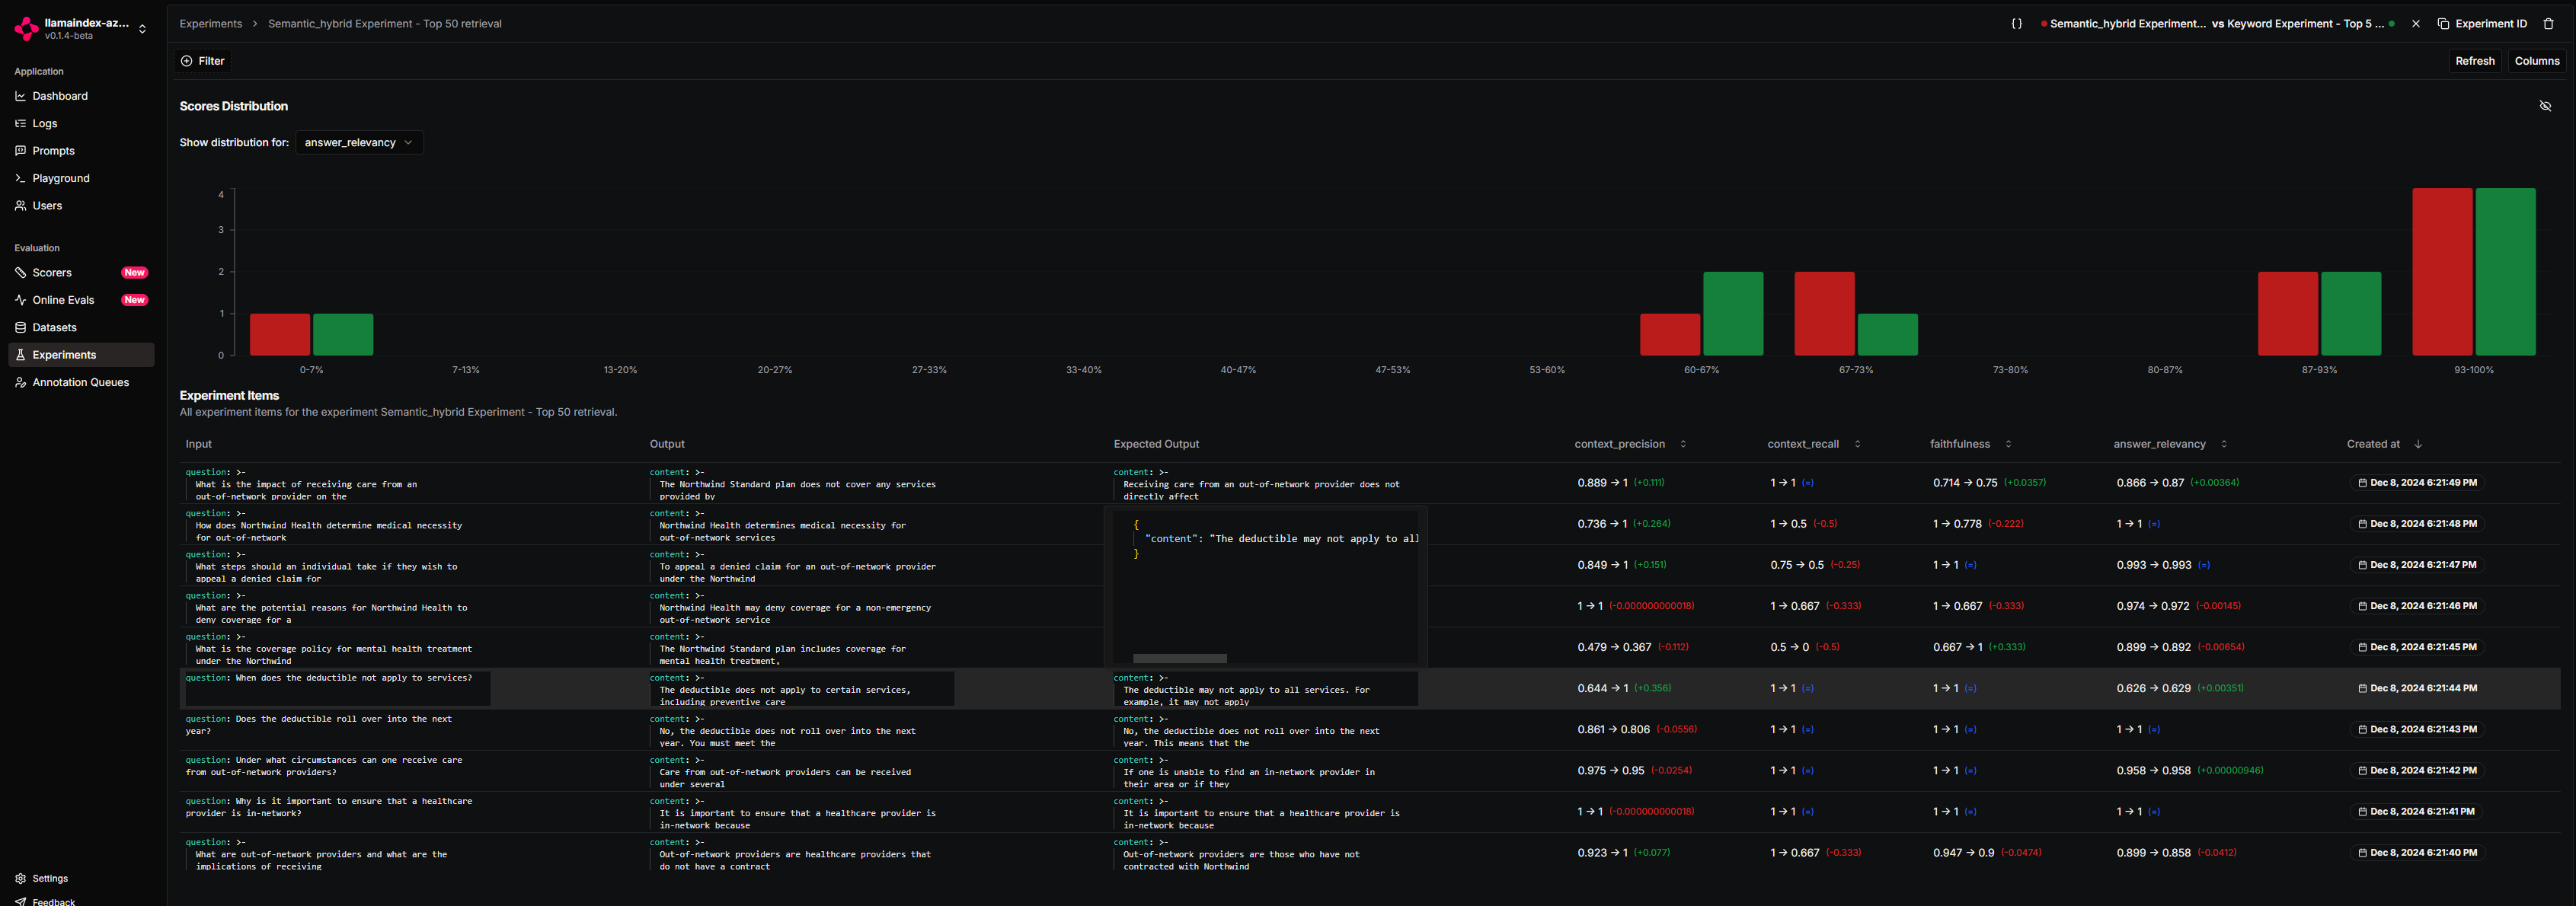

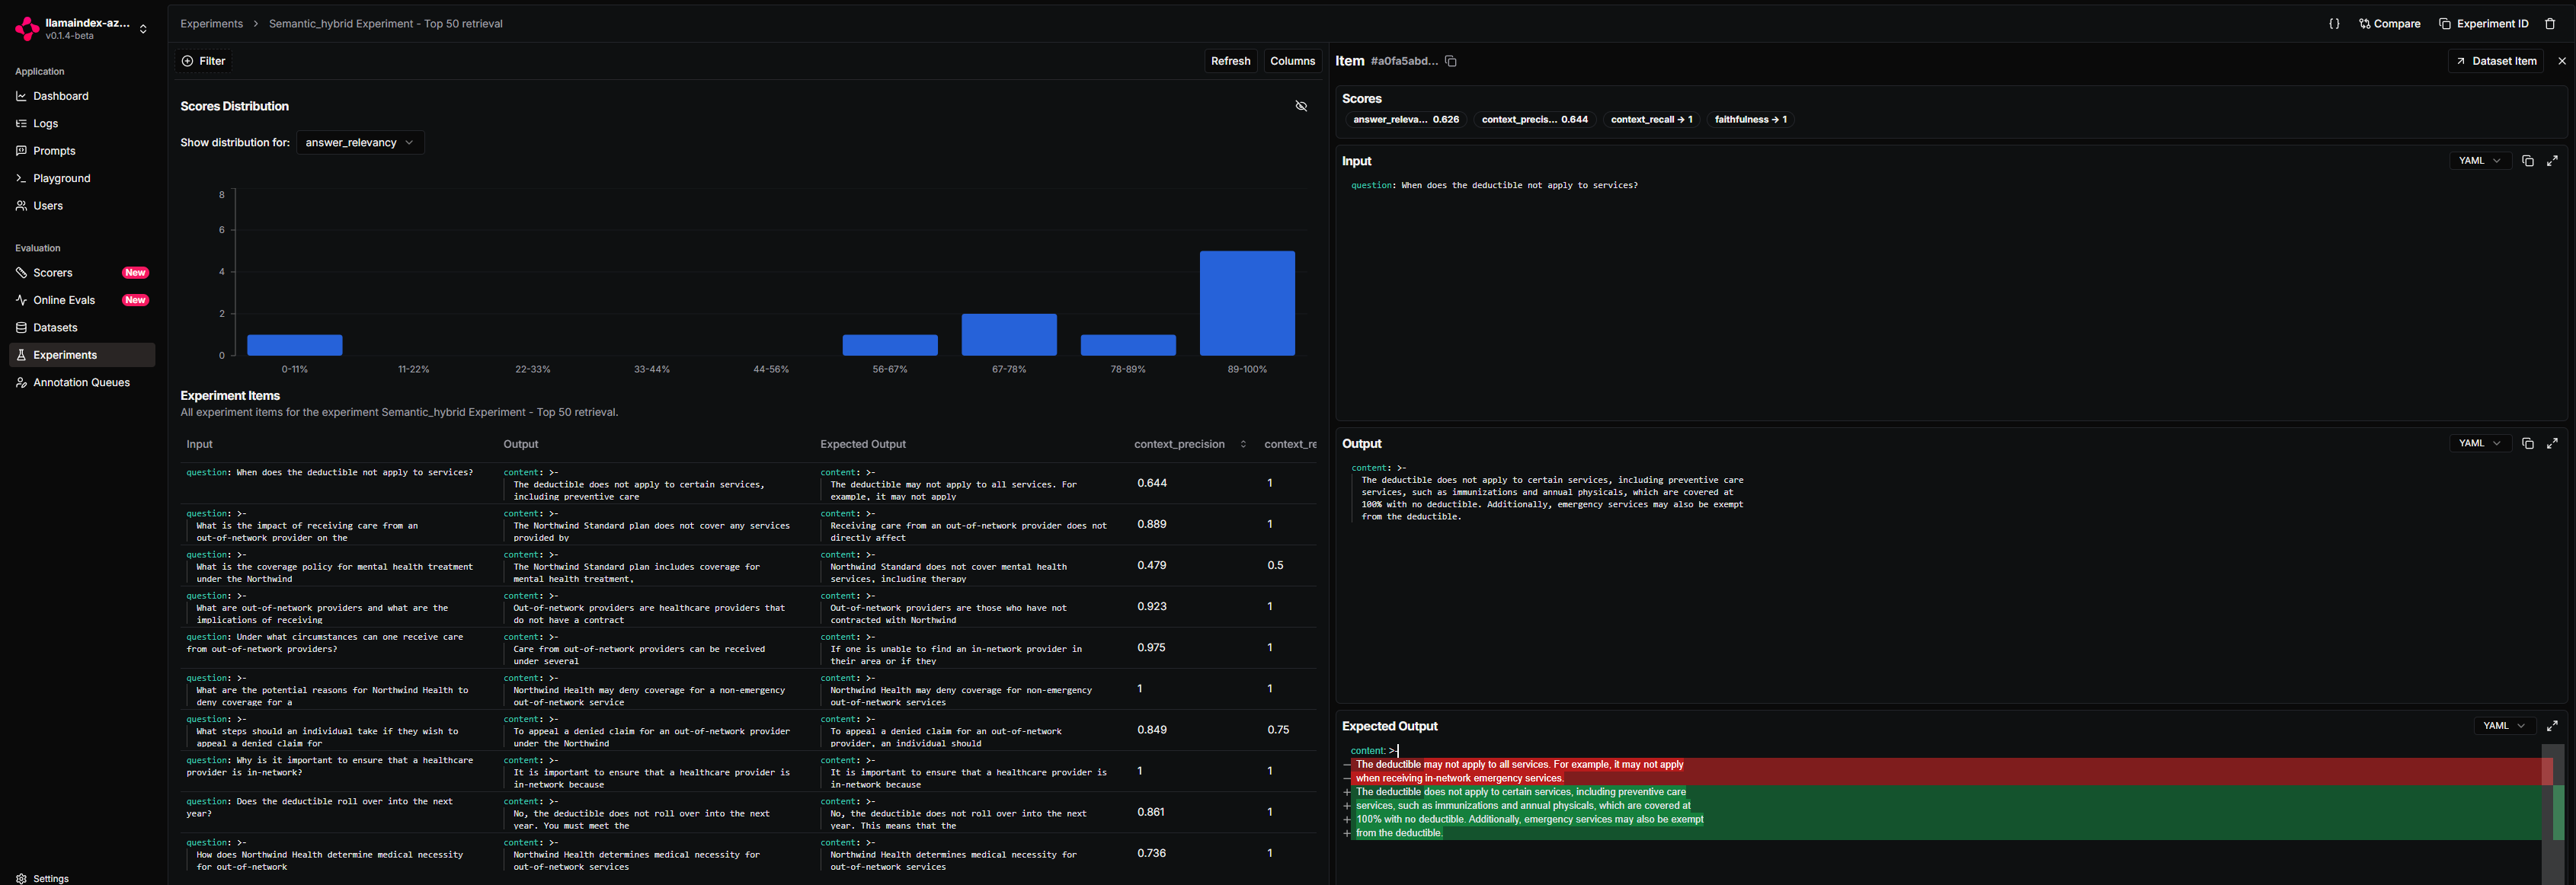


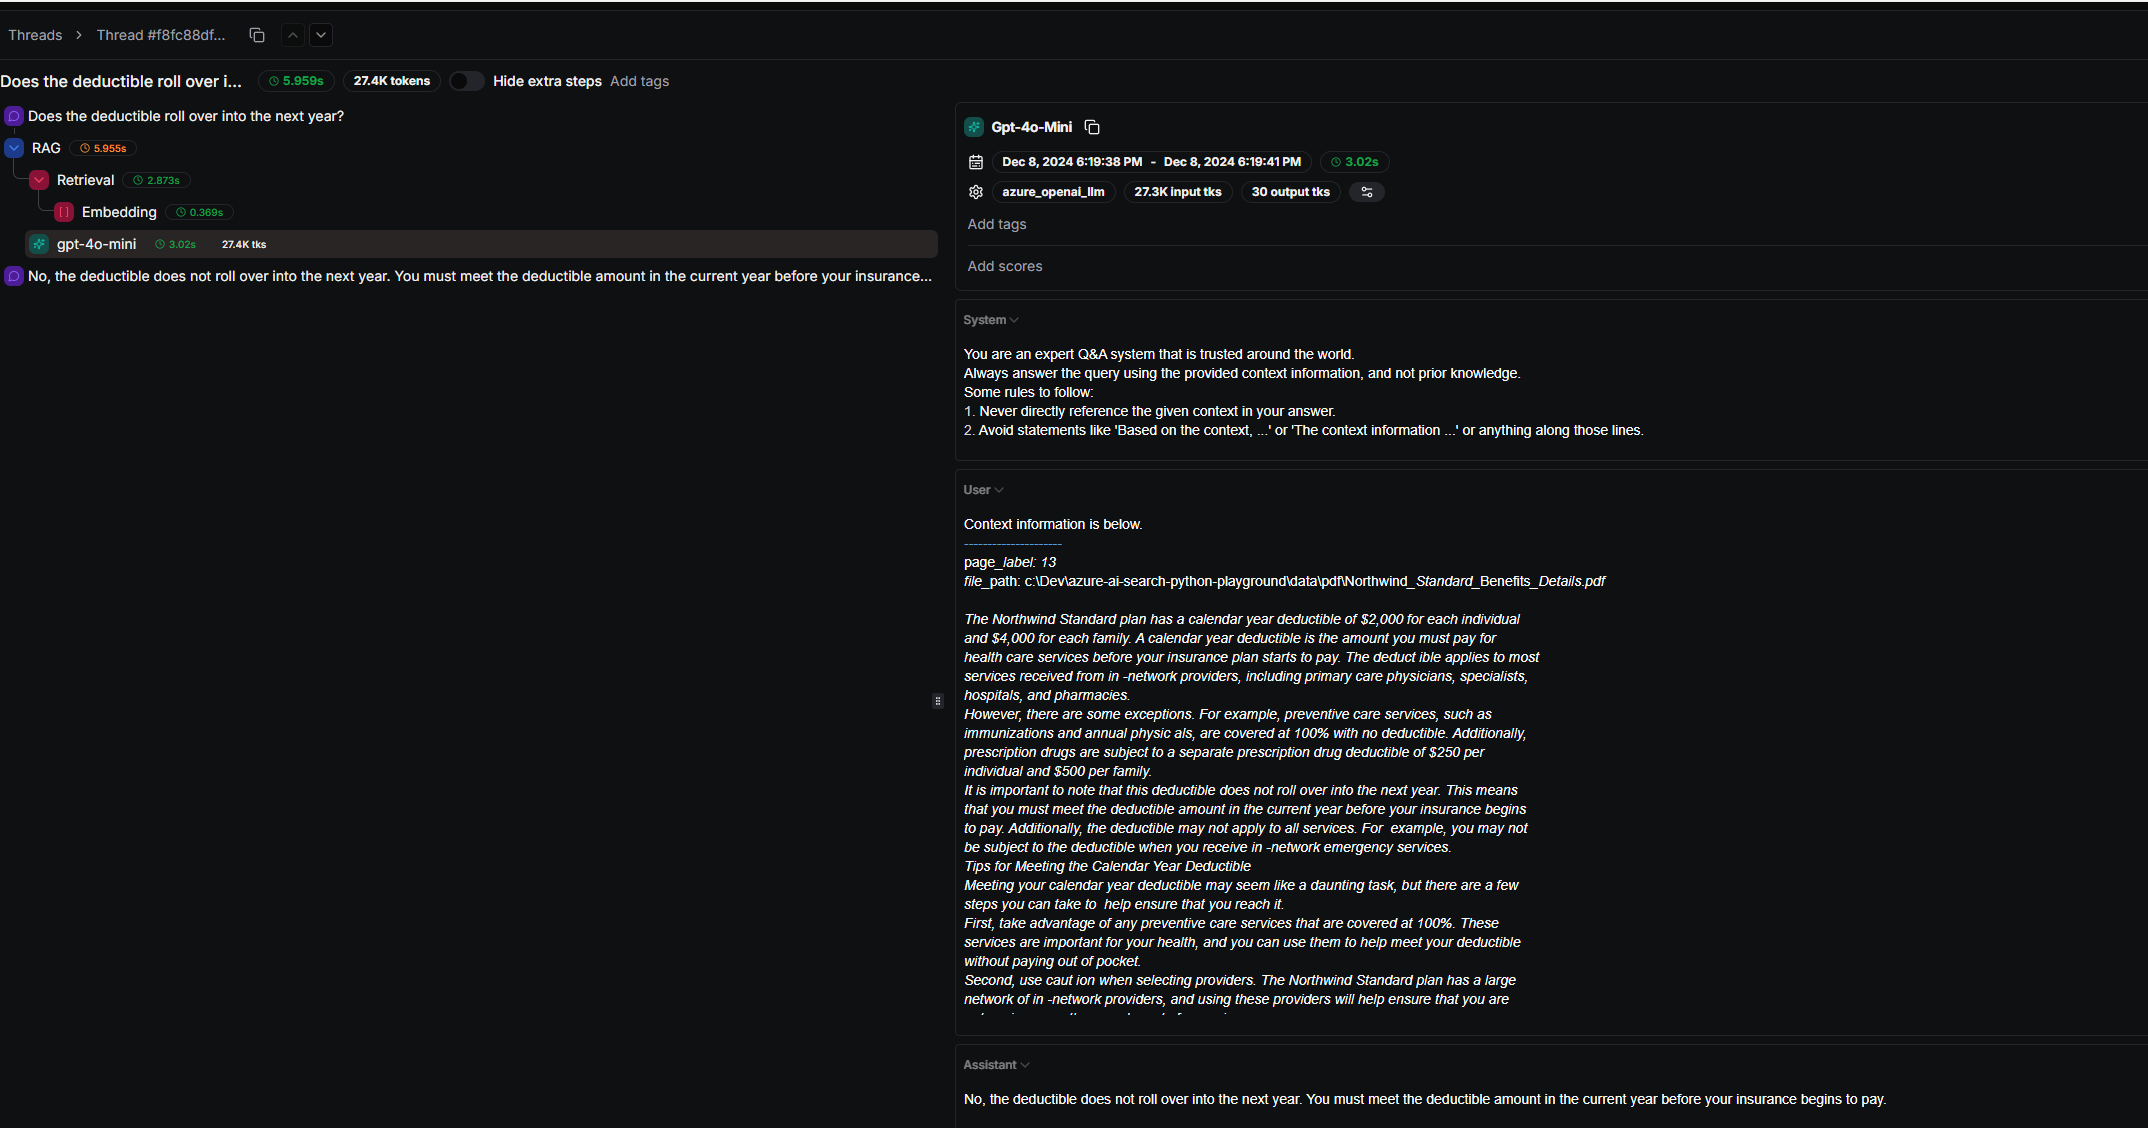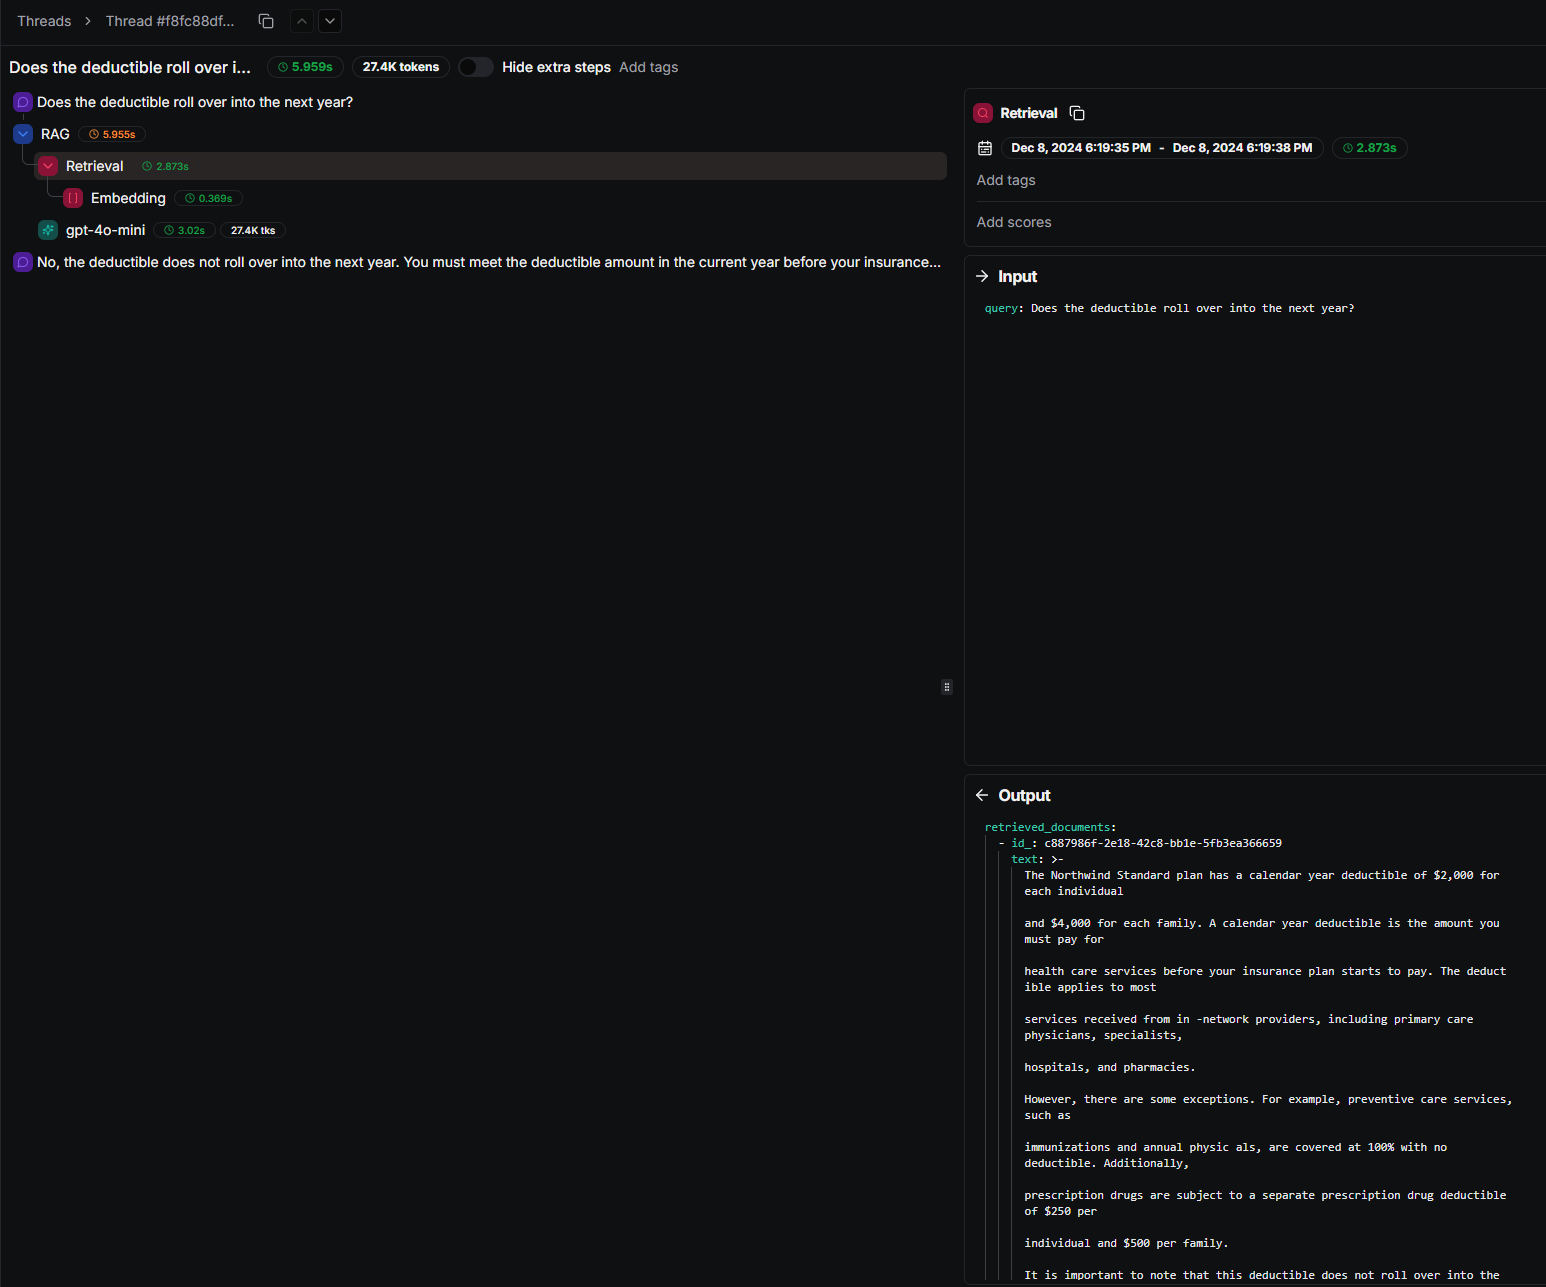
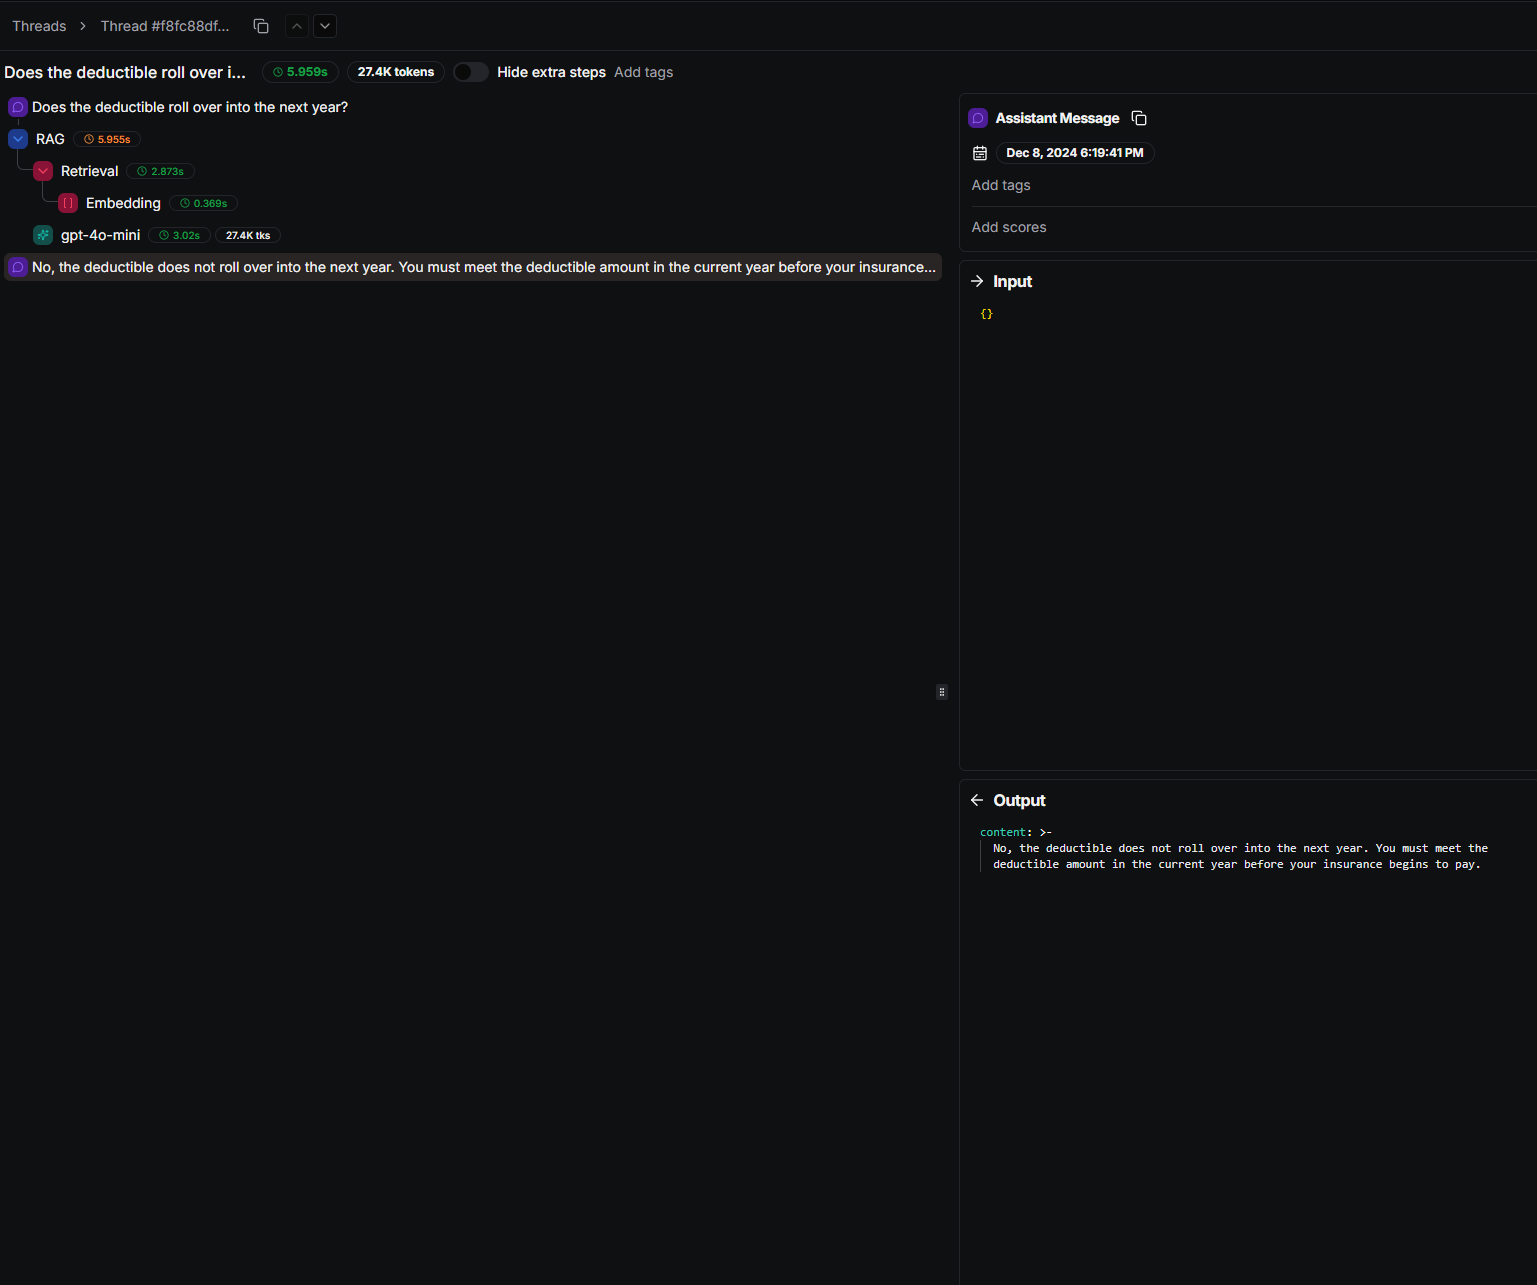